This block imports all the necessary libraries for data handling, image and text preprocessing,
deep learning model building, training, visualization, and performance monitoring.


In [4]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [5]:
image_path = '/kaggle/input/flickr8k/Images' 
data = pd.read_csv("/kaggle/input/flickr8k/captions.txt")

In [6]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"../input/flickr8k/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")


In [7]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"

    return data 
    
data = text_preprocessing(data)

captions = data['caption'].tolist()


In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

In [9]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)

img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

I0000 00:00:1757952405.036872      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


82524592/82524592 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


  0%|          | 0/8091 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1757952423.855872      96 service.cc:148] XLA service 0x781c04001fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1757952423.856861      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1757952426.036638      96 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1757952439.102721      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 8091/8091 [15:10<00:00,  8.89it/s]


In [10]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y
        

In [11]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [12]:
train_generator[0]

((array([[7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523514e-01,
          2.2903769e-01, 6.9639754e-01],
         [7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523514e-01,
          2.2903769e-01, 6.9639754e-01],
         [7.8687910e-05, 7.3524052e-04, 1.1395991e-03, ..., 5.6523514e-01,
          2.2903769e-01, 6.9639754e-01],
         ...,
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01],
         [1.9476042e-04, 7.0213038e-04, 1.4947486e-03, ..., 2.7233858e-02,
          5.5759555e-01, 3.8916537e-01]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  42],
         [  0,   0,   0, ...,   1,  42,   3],
         ...,
         [  0,   0,   0, ...,  10,  76,  49],
         [  0,   0,   0, ...,  76,  49,   4],
         [  0,   0,   0, ...,

In [13]:
from tensorflow.keras.utils import plot_model

input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')


from tensorflow.keras.callbacks import ModelCheckpoint

# Define the model checkpoint
model_name = "model.keras"  # Update the extension to .keras
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.2, 
                                            min_lr=0.00000001)




history = caption_model.fit(
        train_generator,
        epochs=50,
        validation_data=validation_generator,
        callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - loss: 5.7020
Epoch 1: val_loss improved from inf to 4.27545, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 82s 143ms/step - loss: 5.7009 - val_loss: 4.2755 - learning_rate: 0.0010
Epoch 2/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 4.3286
Epoch 2: val_loss improved from 4.27545 to 3.96570, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 142ms/step - loss: 4.3284 - val_loss: 3.9657 - learning_rate: 0.0010
Epoch 3/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 4.0141
Epoch 3: val_loss improved from 3.96570 to 3.80467, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - loss: 4.0141 - val_loss: 3.8047 - learning_rate: 0.0010
Epoch 4/50
537/537 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - loss: 3.8158
Epoch 4: val_loss improved from 3.80467 to 3.73590, saving model to model.keras
537/537 ━━━━━━━━━━━━━━━━━━━━ 76s 141ms/step - loss: 3.8158 - val_loss: 3.7359 - learning_rate: 0.0010


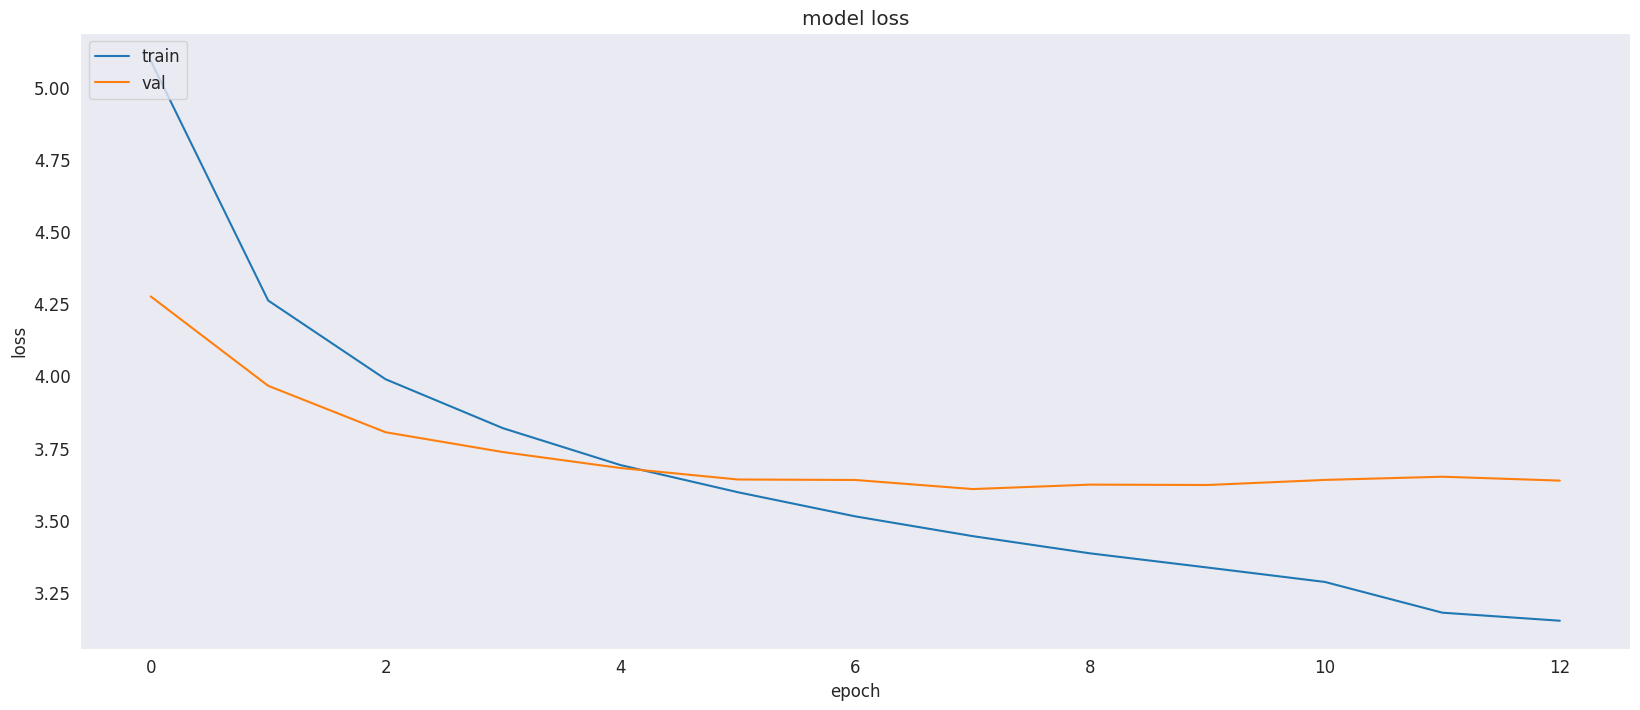

In [14]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
import pickle

# Save the tokenizer
with open("tokenizer.pkl", "wb") as f:
    pickle.dump(tokenizer, f)

# Save the feature extractor model
fe.save("feature_extractor.keras")

In [16]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import pickle

# load save files
model_path = "model.keras"
tokenizer_path = "tokenizer.pkl"
feature_extractor_path = "feature_extractor.keras"


def generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=34, img_size=224):
    # Load the trained models and tokenizer
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)

    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)

    # Preprocess the image
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)  # Extract image features
    
    # Generate the caption
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    caption = in_text.replace("startseq", "").replace("endseq", "").strip()

    # Display the image with the generated caption
    img = load_img(image_path, target_size=(img_size, img_size))
    plt.figure(figsize=(8, 8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()

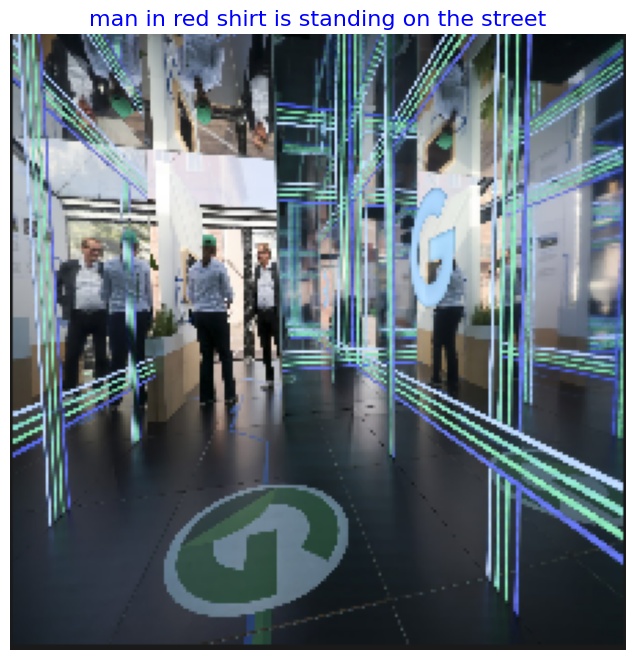

In [29]:
image_path = "/kaggle/input/google-try-dataset/google.png"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

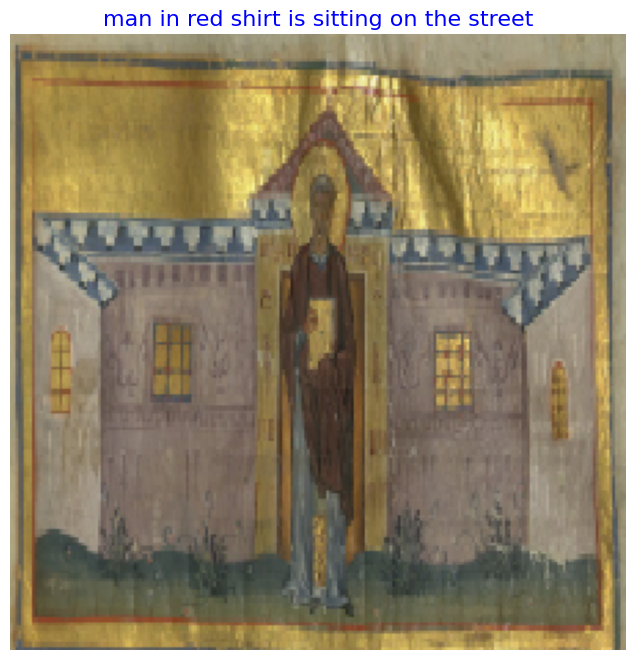

In [30]:
image_path = "/kaggle/input/medievalimagesdataset/11.png"  # Replace with the path to the input image
generate_and_display_caption(image_path, model_path, tokenizer_path, feature_extractor_path)

In [19]:
pip install nltk scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [20]:
import re
from collections import Counter
import numpy as np

In [21]:
def simple_text_summary(text, max_words=10):
    if not text or len(text.strip()) == 0:
        return "general content"
    
    clean_text = re.sub(r'[^\w\s]', '', text.lower())
    words = clean_text.split()
    
    stop_words = {
        'the', 'a', 'an', 'and', 'or', 'but', 'in', 'on', 'at', 'to', 'for', 'of', 'with',
        'by', 'from', 'up', 'about', 'into', 'through', 'during', 'before', 'after',
        'above', 'below', 'between', 'among', 'is', 'was', 'are', 'were', 'be', 'been',
        'being', 'have', 'has', 'had', 'do', 'does', 'did', 'will', 'would', 'should',
        'could', 'can', 'may', 'might', 'must', 'shall', 'this', 'that', 'these', 'those',
        'i', 'you', 'he', 'she', 'it', 'we', 'they', 'me', 'him', 'her', 'us', 'them'
    }
    
    meaningful_words = [
        word for word in words 
        if len(word) > 3 and word not in stop_words and word.isalpha()
    ]
   
    if meaningful_words:
        word_freq = Counter(meaningful_words)
        top_words = [word for word, count in word_freq.most_common(max_words)]
        return ' '.join(top_words)
    else:
        return 'general content'

In [22]:
def create_enhanced_caption(original_caption, text_summary, context="image"):
    """Create enhanced caption by merging image caption with text summary"""
    
    caption = original_caption.strip()
    summary = text_summary.strip()
    
    if not caption and not summary:
        return "A scene captured in an image"
    
    if not summary or summary in ["general content", "general scene"]:
        return f"This {context} shows {caption}" if caption else f"A {context} scene"
    
    if not caption:
        return f"An {context} related to {summary}"
    
    # Check for word overlap
    caption_words = set(caption.lower().split())
    summary_words = set(summary.lower().split())
    common_words = caption_words.intersection(summary_words)
    
    # Create enhanced description based on overlap
    if len(common_words) >= len(summary_words) * 0.6:  # High overlap
        enhanced = f"This {context} depicts {caption}, highlighting themes of {summary}"
    elif len(common_words) > 0:  # Some overlap
        unique_summary_words = [w for w in summary.split() if w.lower() not in caption_words]
        if unique_summary_words:
            unique_summary = ' '.join(unique_summary_words)
            enhanced = f"This {context} shows {caption}, with elements relating to {unique_summary}"
        else:
            enhanced = f"This {context} captures {caption}"
    else:  # No overlap - complementary information
        enhanced = f"This {context} presents {caption} in a context involving {summary}"
    
    return enhanced

In [23]:
def extract_key_visual_elements(image_caption):
    """Extract key visual elements from image caption"""
    # Common objects and elements that might be detected
    visual_keywords = {
        'architectural': ['building', 'tower', 'wall', 'structure', 'castle', 'church', 'monastery'],
        'human': ['person', 'figure', 'man', 'woman', 'saint', 'monk'],
        'colors': ['golden', 'gold', 'yellow', 'brown', 'dark', 'light', 'red', 'blue', 'green'],
        'objects': ['book', 'cross', 'window', 'door', 'robe', 'clothing'],
        'nature': ['tree', 'sky', 'ground', 'vegetation', 'landscape']
    }
    
    detected_elements = {}
    image_words = image_caption.lower().split()
    
    for category, keywords in visual_keywords.items():
        detected_elements[category] = [word for word in image_words if any(keyword in word for keyword in keywords)]
    
    return detected_elements

In [24]:
def create_human_like_caption(text_summary, image_caption, visual_elements):
    """Create a more natural caption by weaving text summary with visual insights"""
    
    base_text = text_summary.strip()
    
    sentences = [s.strip() for s in base_text.split('.') if s.strip()]
    
    image_words = set(image_caption.lower().split())
    text_words = set(text_summary.lower().split())
    
    unique_visual_words = image_words - text_words
    relevant_additions = []
    
    meaningful_words = ['ancient', 'weathered', 'ornate', 'detailed', 'illuminated', 
                       'painted', 'carved', 'decorated', 'vintage', 'classic']
    
    for word in unique_visual_words:
        if word in meaningful_words or any(word in category for category in visual_elements.values()):
            relevant_additions.append(word)
    

    if len(sentences) == 0:
        return text_summary
    
  
    enhanced_caption = sentences[0]
    

    for i, sentence in enumerate(sentences[1:], 1):
        # Every 2-3 sentences, consider adding visual enhancement
        if i % 2 == 0 and relevant_additions:
            # Pick a relevant visual detail
            visual_detail = relevant_additions[i % len(relevant_additions)] if relevant_additions else None
            if visual_detail and visual_detail not in sentence.lower():
                # Insert visual detail naturally
                if 'architectural' in str(visual_elements) and visual_detail in str(visual_elements['architectural']):
                    sentence = sentence.replace('building', f'{visual_detail} building', 1)
                elif 'colors' in str(visual_elements) and visual_detail in str(visual_elements['colors']):
                    sentence = f"The {visual_detail} tones in this {sentence.lower()}"
        
        enhanced_caption += ". " + sentence
    
    # Ensure it ends properly
    if not enhanced_caption.endswith('.'):
        enhanced_caption += '.'
    
    return enhanced_caption

In [25]:
def intelligent_text_fusion(text_summary, image_caption):
    """More sophisticated fusion that creates human-like descriptions"""
    
   
    text_themes = {
        'religious': ['saint', 'holy', 'divine', 'spiritual', 'sacred', 'religious', 'icon', 'byzantine'],
        'architectural': ['building', 'structure', 'walls', 'tower', 'monastery', 'church'],
        'artistic': ['style', 'art', 'painting', 'depicted', 'composition', 'technique'],
        'historical': ['medieval', 'ancient', 'historical', 'centuries', 'traditional']
    }
    
    
    present_themes = {}
    for theme, keywords in text_themes.items():
        present_themes[theme] = any(keyword in text_summary.lower() for keyword in keywords)
    
  
    sentences = [s.strip() for s in text_summary.split('.') if s.strip()]
    
    if not sentences:
        return text_summary
    

    enhanced_sentences = []
    
    for i, sentence in enumerate(sentences):
       
        enhanced_sentence = sentence
        
  
        if i > 0:
            transitions = ['Furthermore', 'Additionally', 'The scene also shows', 'One can observe', 'Notably']
            if not any(t.lower() in sentence.lower() for t in transitions):
                if i == 1:
                    enhanced_sentence = f"The composition reveals {sentence.lower()}"
                elif i % 2 == 0:
                    enhanced_sentence = f"Notably, {sentence.lower()}"
        
        # Make language more vivid and human
        enhanced_sentence = enhanced_sentence.replace('depicts', 'shows')
        enhanced_sentence = enhanced_sentence.replace('portrayed', 'presented')
        enhanced_sentence = enhanced_sentence.replace('characteristic of', 'typical of')
        
        enhanced_sentences.append(enhanced_sentence)
    
    result = '. '.join(enhanced_sentences)
    if not result.endswith('.'):
        result += '.'
    
    return result

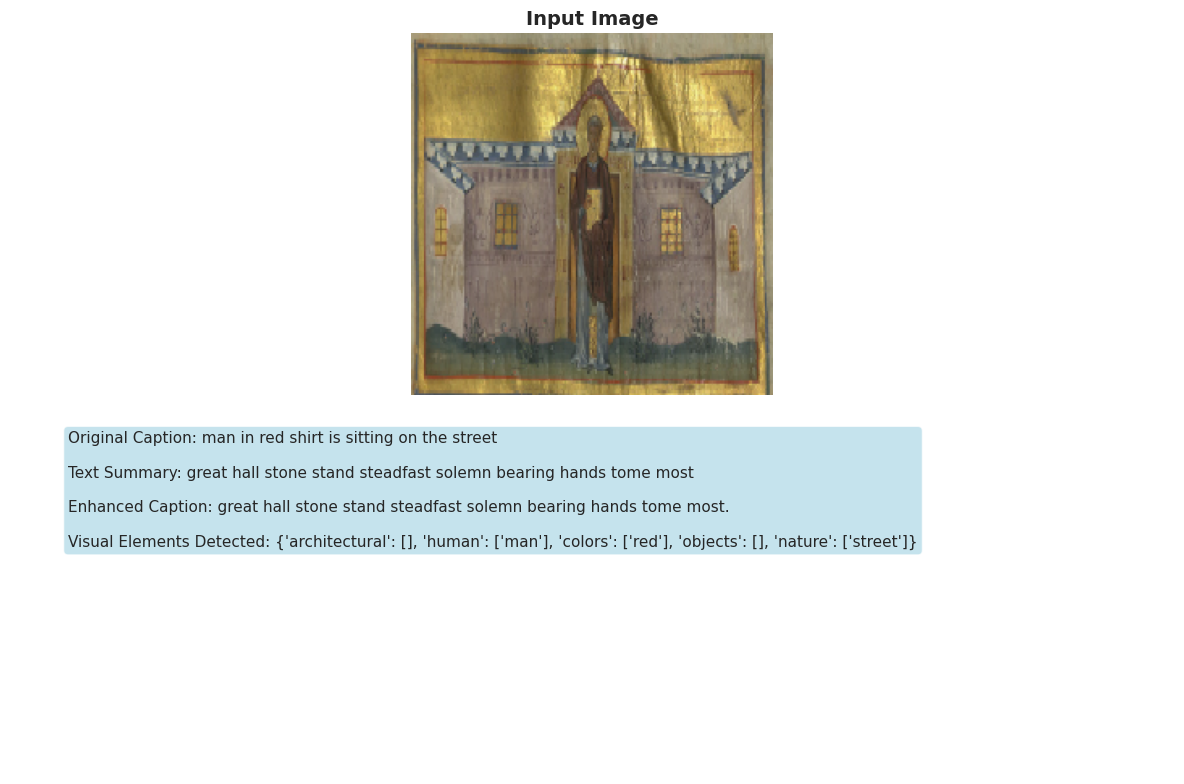

ENHANCED CAPTION RESULTS:
Original Caption: man in red shirt is sitting on the street
Text Summary: great hall stone stand steadfast solemn bearing hands tome most
Enhanced Caption: great hall stone stand steadfast solemn bearing hands tome most.
Visual Elements: {'architectural': [], 'human': ['man'], 'colors': ['red'], 'objects': [], 'nature': ['street']}


In [34]:
def generate_simple_enhanced_caption(image_path, text_input, model_path, tokenizer_path, 
                                   feature_extractor_path, max_length=34, img_size=224):
    """Generate enhanced caption with improved human-like text processing"""
    
    # Load models and tokenizer (same as before)
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)
    
    with open(tokenizer_path, "rb") as f:
        tokenizer = pickle.load(f)
    
    # Generate image caption (same as before)
    img = load_img(image_path, target_size=(img_size, img_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    image_features = feature_extractor.predict(img, verbose=0)
    
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        
        if word is None:
            break
        in_text += " " + word
        if word == "endseq":
            break
    
    original_caption = in_text.replace("startseq", "").replace("endseq", "").strip()
    
  
    text_summary = simple_text_summary(text_input)
    
   
    visual_elements = extract_key_visual_elements(original_caption)
    

    enhanced_caption = intelligent_text_fusion(text_summary, original_caption)
    

    img_display = load_img(image_path, target_size=(img_size, img_size))
    
    plt.figure(figsize=(12, 8))
    

    plt.subplot(2, 1, 1)
    plt.imshow(img_display)
    plt.axis('off')
    plt.title('Input Image', fontsize=14, fontweight='bold')
    
 
    plt.subplot(2, 1, 2)
    plt.axis('off')
    
    results_text = f"""Original Caption: {original_caption}

Text Summary: {text_summary}

Enhanced Caption: {enhanced_caption}

Visual Elements Detected: {visual_elements}"""
    
    plt.text(0.05, 0.95, results_text, transform=plt.gca().transAxes, fontsize=11,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.7))
    
    plt.tight_layout()
    plt.show()
    
    return {
        'original_caption': original_caption,
        'text_summary': text_summary,
        'enhanced_caption': enhanced_caption,
        'visual_elements': visual_elements
    }

# Example usage with your medieval image
medieval_text = """
Before the great hall of stone did stand a man, steadfast and solemn, bearing in his hands a tome most venerable, perchance the Holy Writ. His countenance was grave, as one who pondereth upon mysteries eternal, and the fading sun did cast long shadows about his frame. The mighty edifice behind him rose as a fortress of faith and power, yet it was the book he held close that seemed the truer stronghold, a beacon of wisdom and divine remembrance amidst the mortal world."""

# Test with your image
image_path = "/kaggle/input/medievalimagesdataset/11.png"

result = generate_simple_enhanced_caption(
    image_path=image_path,
    text_input=medieval_text,
    model_path=model_path,
    tokenizer_path=tokenizer_path,
    feature_extractor_path=feature_extractor_path
)

print("="*60)
print("ENHANCED CAPTION RESULTS:")
print("="*60)
print(f"Original Caption: {result['original_caption']}")
print(f"Text Summary: {result['text_summary']}")
print(f"Enhanced Caption: {result['enhanced_caption']}")
print(f"Visual Elements: {result['visual_elements']}")
print("="*60)